In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
from torch import Generator
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from tempfile import TemporaryFile
import os

In [36]:
%cd /content/drive/MyDrive/project_data

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-6d53e17f1080>", line 1, in <module>
    get_ipython().magic('cd /content/drive/MyDrive/project_data')
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-84>", line 2, in cd
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
FileNotFoundError: [Errno 2] No such file or directory

During handling of t

FileNotFoundError: ignored

# Hyperparams

In [2]:
hyperparams = {
    'validation_split' : 0.2,
    'split_seed' : 42,
    'batch_size' : 128,
    'lr' : 2e-3,
    'weight_decay' : 5e-6,
    'class_num' : 11, # need to change
    'dropout_prob' : 0.2,
    'rnn_hidden_size' : 256,
    'rnn_layer_num' : 3,
    'soft_aug_size' : 40
    }

alpha = [np.random.beta(8,8) for _ in range(hyperparams['soft_aug_size'])]

modes = ('train', 'dev', 'soft')

# Old Data (unbalanced)

In [ ]:
train_data = np.load("train_data_num.npy", allow_pickle=True)
# clade
train_labels_clade = np.load('train_label_clade_num.npy', allow_pickle=True)
# pango
train_labels_pango = np.load('train_label_pango_num.npy',allow_pickle=True)

val_data = np.load("validation_data_num.npy", allow_pickle=True)
# clade
val_labels_clade = np.load('validation_label_clade_num.npy', allow_pickle=True)
# pango
val_labels_pango = np.load('validation_label_pango_num.npy',allow_pickle=True)

In [ ]:
# just taking 2/3 of the training data
train_data = train_data[:len(train_data)*2//3]
train_labels_clade = train_labels_clade[:len(train_labels_clade)*2//3]
assert(len(train_data) == len(train_labels_clade))

In [ ]:
# run for CLADE
assert(set(np.unique(train_labels_clade)) == set(np.unique(val_labels_clade)))
hyperparams['class_num'] = len(np.unique(val_labels_clade))
hyperparams['class_num']
np.unique(val_labels_clade)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
print(train_data.shape)
print(np.shape(train_labels_clade))
print(val_data.shape)
print(np.shape(val_labels_clade))

(420522,)
(420522,)
(70088,)
(70088,)


# Balanced Data

In [3]:
train_data = np.load("train_data_balanced.npy", allow_pickle=True)
# clade
train_labels_clade = np.load('train_label_balanced.npy', allow_pickle=True)


val_data = np.load("validation_data_balanced.npy", allow_pickle=True)
# clade
val_labels_clade = np.load('validation_label_balanced.npy', allow_pickle=True)


In [ ]:
# just taking 2/3 of the training data
train_data = train_data[:len(train_data)*2//3]
train_labels_clade = train_labels_clade[:len(train_labels_clade)*2//3]
assert(len(train_data) == len(train_labels_clade))

In [4]:
# run for CLADE
assert(set(np.unique(train_labels_clade)) == set(np.unique(val_labels_clade)))
hyperparams['class_num'] = len(np.unique(val_labels_clade))
hyperparams['class_num']
np.unique(val_labels_clade)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [5]:
print(train_data.shape)
print(np.shape(train_labels_clade))
print(val_data.shape)
print(np.shape(val_labels_clade))

(43434,)
(43434,)
(4842,)
(4842,)


In [6]:
train_data[0]

array([11,  5, 19, ..., 22, 17, 24])

# BERT embedding

In [ ]:
train_data = np.load("train_embeddings.npy", allow_pickle=True)
# clade
train_labels_clade = np.load('train_label_balanced.npy', allow_pickle=True)


val_data = np.load("valid_embeddings.npy", allow_pickle=True)
# clade
val_labels_clade = np.load('validation_label_balanced.npy', allow_pickle=True)


In [ ]:
# run for CLADE
print(set(np.unique(train_labels_clade)))
print(set(np.unique(val_labels_clade)))
assert(set(np.unique(train_labels_clade)) == set(np.unique(val_labels_clade)))
hyperparams['class_num'] = len(np.unique(val_labels_clade))
hyperparams['class_num']
np.unique(val_labels_clade)

{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 1, 2, 3, 4, 5, 6, 7, 8}


array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
print(train_data.shape)
print(np.shape(train_labels_clade))
print(val_data.shape)
print(np.shape(val_labels_clade))

(43434, 2048)
(43434,)
(4842, 2048)
(4842,)


In [ ]:
print(train_data[0].dtype)

float32


# data loading

In [7]:
class Dataset(Dataset):
    def __init__(self, X, Y = None, test=False, augment=None, aug_size=None):
        self.X = X
        self.Y = Y
        self.test = test
        self.augment = augment
        self.aug_size = aug_size
        if augment == "random_replace":
            self._random_replace()

    def __len__(self):
        assert(len(self.X) == len(self.Y))
        return len(self.X)

    def __getitem__(self,idx):
        x = torch.from_numpy(self.X[idx].astype(float)).float()
        x = torch.unsqueeze(x,dim=1)
        if not self.test:
            y = self.Y[idx]
        else:
            y = -1
        return (x,y)

    def _random_replace(self):
        ori_len = self.X.shape[0]
        aug_idx = np.random.choice(range(ori_len), size=self.aug_size,replace=False)
        aug_set = [self.X[i] for i in aug_idx]
        aug_data = []
        aug_labels = []
        for i, data in enumerate(aug_set):
            j = np.random.choice(range(data.shape[0]))
            data[j] = np.random.choice(range(24))
            aug_data.append(data)
            aug_labels.append(self.Y[aug_idx[i]])
        self.X = np.append(self.X, np.array(aug_data, dtype='O'), axis=0)
        self.Y = np.append(self.Y, np.array(aug_labels, dtype='O'), axis=0)


def pad_collate(batch):
    (xx,y) = zip(*batch)

    xx_pad = pad_sequence(xx,padding_value=0) 

    x_lens = torch.LongTensor([len(x) for x in xx])
    return (xx_pad, x_lens, torch.tensor(y))

In [8]:
class SoftDataset(Dataset):
    def __init__(self, X_a, X_b, Y):
        self.X_a = X_a
        self.X_b = X_b
        self.Y = Y

    def __len__(self):
        assert(len(self.X_a) == len(self.Y))
        return len(self.Y)

    def __getitem__(self,idx):
        x_a = torch.Tensor(self.X_a[idx]).float()
        x_a = torch.unsqueeze(x_a,dim=1)
        x_b = torch.Tensor(self.X_b[idx]).float()
        x_b = torch.unsqueeze(x_b,dim=1)
        y = self.Y[idx]

        return (x_a, x_b, y, idx)

def mix_pad_collate(batch):
    (xx_a, xx_b ,y, idx) = zip(*batch)

    xx_pad_a = pad_sequence(xx_a,padding_value=0) 
    xx_pad_b = pad_sequence(xx_b,padding_value=0) 

    # y = pad_sequence(y,padding_value=0)

    x_lens_a = torch.LongTensor([len(x) for x in xx_a])
    x_lens_b = torch.LongTensor([len(x) for x in xx_b])
    return (xx_pad_a, x_lens_a, xx_pad_b, x_lens_b, torch.tensor(y), idx)

In [9]:
def generate_mix_data(train_data, train_labels, aug_size):
    num_aug = 0
    pairs = []
    input_a = []
    input_b = []
    labels = []

    while(num_aug < aug_size):
        i, j = np.random.randint(0, len(train_data)), np.random.randint(0, len(train_data))
        if i != j and (i, j) not in pairs:
            _a = alpha[num_aug]
            pairs.append((i, j))
            input_a.append(train_data[i])
            input_b.append(train_data[j])
            one_hot_a = np.zeros(len(np.unique(train_labels)), dtype=float)
            one_hot_b = np.zeros(len(np.unique(train_labels)), dtype=float)
            one_hot_a[train_labels[i]] = 1
            one_hot_b[train_labels[j]] = 1

            one_hot = list(_a * one_hot_a + (1-_a) * one_hot_b)
            labels.append(one_hot)

            num_aug += 1

    return SoftDataset(input_a, input_b, labels)


In [10]:
soft_dataset = generate_mix_data(train_data, train_labels_clade, hyperparams['soft_aug_size'])

In [11]:
train_dataset = Dataset(train_data, train_labels_clade, augment="random_replace", aug_size=40)
val_dataset = Dataset(val_data, val_labels_clade)

In [12]:
datasets = {'train': train_dataset, "dev": val_dataset, "soft": soft_dataset}

data_loader = {
    mode: DataLoader(
        dataset = datasets[mode],
        batch_size = hyperparams['batch_size'],
        shuffle = (mode == 'train' or mode == 'soft'),
        collate_fn = mix_pad_collate if mode == 'soft' else pad_collate
    )
    for mode in modes
}

In [13]:
for (data, data_len, target) in data_loader['dev']:
    print(target)

    # print("data_a: ",data_a)
    # print("data len_a: ",data_len_a)
    # print("data_b: ",data_b)
    # print("data len_b: ",data_len_b)
    # print("target: ",target)
    # print(idx)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# Base Model

In [14]:
def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight.data)
        nn.init.normal_(module.bias.data)

    elif isinstance(module, nn.Conv2d) or isinstance(module, nn.Conv1d):
        nn.init.kaiming_normal_(module.weight, mode='fan_out')

    elif isinstance(module, nn.RNNBase) or isinstance(module, nn.LSTMCell) or isinstance(module, nn.GRUCell) or isinstance(module,nn.LSTM):
        for name, param in module.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.normal_(param.data)

    elif isinstance(module, nn.BatchNorm1d) or isinstance(module, nn.BatchNorm2d):
        module.weight.data.normal_(1.0, 0.02)

In [51]:
# hard code with number
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = torch.nn.Sequential(
             nn.Conv1d(1, 128, 3, padding=1, bias=False),
             nn.BatchNorm1d(128),
             nn.ReLU(inplace=False))
        
        self.lstm = nn.LSTM(input_size=128, hidden_size=256, num_layers=3,
                            bias=True, dropout=0.0, bidirectional=True)
        self.out_layer = nn.Sequential(nn.Dropout(0.2),
                            nn.Linear(256*2,256),
                            nn.Dropout(0.2),
                            nn.Linear(256, hyperparams['class_num']))
        

    def forward(self, x, lengths, x_b=None, lengths_b=None, ids=None):
        print(x.shape)
        #print(1, x.shape) # x dim = (T,B,F)  (1272,1,1)
        x = x.permute(1,2,0) # x dim = (B,F,T) 
        x = self.cnn(x) # x dim = (B, F', T')
        # x = x.permute(2,0,1) # x dim = (T', B, F')

        if x_b != None:
            x_b = x_b.permute(1,2,0) # x dim = (B,F,T) 
            x_b = self.cnn(x_b) # x dim = (B, F', T')

            for i, idx in enumerate(ids):
                _a = alpha[idx]
                x[i] = x[i] * _a + x_b[i] * (1-_a)
            # x_b = x_b.permute(2,0,1) # x dim = (T', B, F')
        
        x = x.permute(2,0,1) # x dim = (T', B, F')



        x_packed = pack_padded_sequence(x, lengths.cpu(), enforce_sorted=False)

        lstm_packed, hidden = self.lstm(x_packed)

        out, out_lengths = pad_packed_sequence(lstm_packed, batch_first=True)
        out = out[:,-1]

        out = self.out_layer(out)
        out = F.softmax(out,dim=1)

        return out, out_lengths

In [52]:

model= Net()
model.apply(init_weights)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=hyperparams['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
model.to(device)

Net(
  (cnn): Sequential(
    (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (lstm): LSTM(128, 256, num_layers=3, bidirectional=True)
  (out_layer): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=9, bias=True)
  )
)

# Training

In [ ]:
from tqdm import tqdm
def train_epoch(model,train_loader,criterion,optimizer):
  print("Training...")
  model.train()
  running_loss = 0.0
  num_correct = 0.0

  start_time = time.time()

  for batch_idx, (data, data_len, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data,data_len = data.to(device),data_len.to(device)
    target = target.to(device)

    outputs,outputs_len = model(data, data_len)
    loss = criterion(outputs,target)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
    num_correct += (torch.argmax(outputs, axis=1) == target).sum().item()

  end_time = time.time()
  running_loss /= len(train_loader)  
  acc = (num_correct / len(datasets['train']))*100.0

  print("Training Loss: ", running_loss, " Time: ", end_time-start_time, "s")
  print("Training accuracy: ", acc, '%')
  return running_loss,acc


In [ ]:
def softXEnt(input, target):
    logprobs = F.log_softmax(input, dim=1)
    return -(target * logprobs).sum() / input.shape[0]

def soft_train_epoch(model,soft_loader,criterion,optimizer):
  print("Training...")
  model.train()
  running_loss = 0.0
  num_correct = 0.0

  start_time = time.time()

  for batch_idx, (data_a, data_len_a, data_b, data_len_b, target, ids) in enumerate(soft_loader):
    optimizer.zero_grad()
    data_a, data_len_a, data_b, data_len_b, target = data_a.to(device), data_len_a.to(device), data_b.to(device), data_len_b.to(device), target.to(device)
    target = target.to(device)

    outputs,outputs_len = model(data_a, data_len_a, data_b, data_len_b, ids)
    loss = softXEnt(outputs,target)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
    # num_correct += (torch.argmax(outputs, axis=1) == target).sum().item()

  end_time = time.time()
  running_loss /= len(soft_loader)  
  # acc = (num_correct / len(datasets['train']))*100.0

  print("Training Loss: ", running_loss, " Time: ", end_time-start_time, "s")
  # print("Training accuracy: ", acc, '%')
  return running_loss

In [ ]:
def val_model(model, dev_loader, criterion):
  print("Validating...")
  with torch.no_grad():
    model.eval()

    running_loss = 0.0
    num_correct = 0.0
    
    for batch_idx, (data,data_len,target) in enumerate(dev_loader):
      print_flag=True
      data,data_len = data.to(device),data_len.to(device)
      # target = target.reshape(-1) 
      target = target.to(device)
      outputs,outputs_len = model(data,data_len)

      if print_flag:
        print('argmax', torch.argmax(outputs, axis=1))
        print('target', target)
        print_flag=False
      # print('output', outputs)


      num_correct += (torch.argmax(outputs, axis=1) == target).sum().item()
  
      loss = criterion(outputs, target).detach()
      running_loss += loss.item()
    
    running_loss /= len(dev_loader)
    acc = (num_correct/len(datasets['dev']))*100.0
    print("Validation Loss: ", running_loss)
    print("Validation Accuracy: ", acc, "%")
    return running_loss, acc

In [ ]:
import time


NUM_EPOCHES = 30

Train_loss = []
Valid_loss = []
Train_acc = []
Valid_acc = []

trailNumber = 3


for i in range(NUM_EPOCHES):
  print("Epoch number ", i)
  train_loss, train_acc = train_epoch(model, data_loader["train"], criterion, optimizer)
  valid_loss, valid_acc = val_model(model, data_loader["dev"], criterion)
  scheduler.step(valid_loss)
  print("learning rate: ", optimizer.param_groups[0]['lr'])

  Train_loss.append(train_loss)
  Valid_loss.append(valid_loss)
  Train_acc.append(train_acc)
  Valid_acc.append(valid_acc)

  print("="*20)

Streaming output truncated to the last 5000 lines.
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
argmax tensor([5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5,
        3, 3, 5, 5, 5, 3, 5, 5, 3, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 3,
        5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 3, 3, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5,
        5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0')
target tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
import time


NUM_EPOCHES = 70

Train_loss = []
Valid_loss = []
Train_acc = []
Valid_acc = []

trailNumber = 3


for i in range(30,NUM_EPOCHES):
  print("Epoch number ", i)
  train_loss, train_acc = train_epoch(model, data_loader["train"], criterion, optimizer)
  valid_loss, valid_acc = val_model(model, data_loader["dev"], criterion)
  scheduler.step(valid_loss)
  print("learning rate: ", optimizer.param_groups[0]['lr'])

  Train_loss.append(train_loss)
  Valid_loss.append(valid_loss)
  Train_acc.append(train_acc)
  Valid_acc.append(valid_acc)

  print("="*20)

Streaming output truncated to the last 5000 lines.
        5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 3, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 3, 5], device='cuda:0')
target tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
argmax tensor([5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5,
        3, 3, 5, 5, 5, 3, 5, 5, 3, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 3,
        5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 3, 3, 5, 5, 5, 5, 5, 5, 

In [ ]:
torch.save(model.state_dict(),"/content/drive/MyDrive/Colab Notebooks/project/model3_bert_emb.t7")

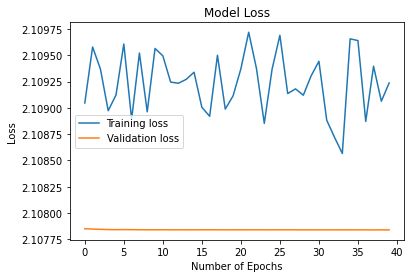

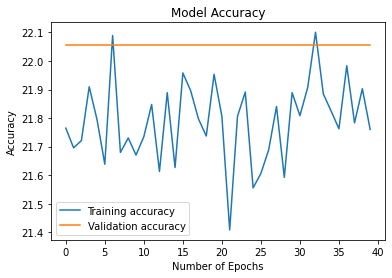

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Train_loss)
plt.plot(Valid_loss)
plt.legend(["Training loss", "Validation loss"])
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/project/model3_bert_train_valid_loss.png")
plt.show()


plt.plot(Train_acc)
plt.plot(Valid_acc)
plt.legend(["Training accuracy", "Validation accuracy"])
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/project/model3_bert_train_valid_acc.png")
plt.show()


In [ ]:
print(Train_loss)
print(Valid_loss)
print(Train_acc)
print(Valid_acc)

[2.1487761413349826, 2.106515947510214, 2.1100573834250955, 2.114494708706351, 2.1127362545798807, 2.1121746876660517, 2.1112505688386807, 2.110814295796787, 2.1107551778064053, 2.110247350440306, 2.110377604821149, 2.1098035363590015, 2.109691689996158, 2.1088954238330615, 2.1097588952849895, 2.109768880114836, 2.1094720146235297, 2.109591890783871, 2.1097797912709852, 2.1091760249698863, 2.1098036394399755, 2.1097256120513466, 2.109769712476169, 2.1089668666615204, 2.1093912895988014, 2.109289581635419, 2.1090241831891676, 2.10905703236075, 2.109213416015401, 2.1097706395037035]
[2.0980471184379175, 2.1003654379593697, 2.111278483742162, 2.1102815395907353, 2.109949281341151, 2.1092552417203, 2.1083069537815295, 2.1084967506559273, 2.1082100899595964, 2.1084463439489665, 2.1081940092538534, 2.108287325030879, 2.1080584557432878, 2.1081445154390837, 2.1080009937286377, 2.1080220843616284, 2.1079391711636593, 2.1079810449951575, 2.1079363446486625, 2.107894928831803, 2.1078553293880664

In [ ]:
# from previously, balanced data with model2
print(Train_loss)
print(Valid_loss)
print(Train_acc)
print(Valid_acc)

[2.1392787190044626, 2.1313355249517105, 2.127023722143734, 2.1257093071937563, 2.124636416575488, 2.1226815938949586, 2.123012591109556, 2.1222676831133227, 2.1228218169773325, 2.1214712493559893, 2.118426306808696, 2.1199606404585, 2.1196013324400957, 2.1183928524746616, 2.1188916024039774, 2.1189867727896745, 2.1186048598850475, 2.1175557634409734, 2.1188400983810425, 2.1209354933570412, 2.121075086733874, 2.1210198633811053, 2.1204829798025244, 2.120311984244515, 2.1169411357711345, 2.1144739508628847, 2.114802622795105, 2.113264267584857, 2.1128294762443094, 2.1117518971948064]
[2.183298857588517, 2.182999748932688, 2.184594734718925, 2.183501334566819, 2.182027882651279, 2.1848321870753638, 2.181132871853678, 2.181896184620104, 2.18109835449018, 2.1796724012023523, 2.181877694631878, 2.1796338871905676, 2.1807382200893604, 2.179370895812386, 2.1785445338801335, 2.179228236800746, 2.1770836742300737, 2.175572875298952, 2.180401883627239, 2.1813284660640515, 2.1808434975774666, 2.1

In [34]:
!pip install torchsummaryX

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [35]:
def mix_pad_collate(batch):
    (xx_a, xx_b ,y, idx) = zip(*batch)

    xx_pad_a = pad_sequence(xx_a,padding_value=0) 
    xx_pad_b = pad_sequence(xx_b,padding_value=0) 

    x_lens_a = [len(x) for x in xx_a]
    x_lens_b = torch.LongTensor([len(x) for x in xx_b])
    return (xx_pad_a, x_lens_a, xx_pad_b, x_lens_b, torch.tensor(y), idx)
for batch_idx, (data,data_len,target) in enumerate(data_loader["train"]):
    print(data.shape)
    print(data_len.shape)
    break

torch.Size([1274, 128, 1])
torch.Size([128])


In [53]:
from torchsummaryX import summary
summary(model, data,data_len)

torch.Size([1274, 128, 1])
                      Kernel Shape      Output Shape     Params Mult-Adds
Layer                                                                    
0_cnn.Conv1d_0         [1, 128, 3]  [128, 128, 1274]      384.0  489.216k
1_cnn.BatchNorm1d_1          [128]  [128, 128, 1274]      256.0     128.0
2_cnn.ReLU_2                     -  [128, 128, 1274]          -         -
3_lstm                           -     [161472, 512]  3.944448M  3.93216M
4_out_layer.Dropout_0            -        [128, 512]          -         -
5_out_layer.Linear_1    [512, 256]        [128, 256]   131.328k  131.072k
6_out_layer.Dropout_2            -        [128, 256]          -         -
7_out_layer.Linear_3      [256, 9]          [128, 9]     2.313k    2.304k
--------------------------------------------------------------------------
                         Totals
Total params          4.078729M
Trainable params      4.078729M
Non-trainable params        0.0
Mult-Adds              4.55488

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_cnn.Conv1d_0,"[1, 128, 3]","[128, 128, 1274]",384.0,489216.0
1_cnn.BatchNorm1d_1,[128],"[128, 128, 1274]",256.0,128.0
2_cnn.ReLU_2,-,"[128, 128, 1274]",NaN,NaN
3_lstm,-,"[161472, 512]",3944448.0,3932160.0
4_out_layer.Dropout_0,-,"[128, 512]",NaN,NaN
5_out_layer.Linear_1,"[512, 256]","[128, 256]",131328.0,131072.0
6_out_layer.Dropout_2,-,"[128, 256]",NaN,NaN
7_out_layer.Linear_3,"[256, 9]","[128, 9]",2313.0,2304.0


# Utils


In [ ]:
def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight.data)
        nn.init.normal_(module.bias.data)

    elif isinstance(module, nn.Conv2d) or isinstance(module, nn.Conv1d):
        nn.init.kaiming_normal_(module.weight, mode='fan_out')

    elif isinstance(module, nn.RNNBase) or isinstance(module, nn.LSTMCell) or isinstance(module, nn.GRUCell):
        for name, param in module.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.normal_(param.data)

    elif isinstance(module, nn.BatchNorm1d) or isinstance(module, nn.BatchNorm2d):
        module.weight.data.normal_(1.0, 0.02)